In [1]:
import pandas as pd
from folium import plugins, Map, CircleMarker
from folium.plugins import HeatMap
import geopandas as gpd
import folium
import geopy
import asyncio
from shapely.geometry import Polygon, Point
from pandas.io.json import json_normalize
import shapely.geometry



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
dest_epsg = '32633'

In [16]:
#Use the shape file to get additional data
sidewalks =gpd.read_file('../data/shape/Sidewalks.shx')
sidewalks['ID'] = sidewalks.index
sidewalks_hazards = gpd.read_file('../data/shape/Sidewalk_Hazards.shx')
ramps_0 = gpd.read_file('../data/Ramps_0_with_score.csv')
sidewalks = sidewalks[['ID','geometry']]
sidewalks = gpd.GeoDataFrame(sidewalks)
sidewalks = sidewalks.to_crs(dest_epsg)
sidewalks_hazards = sidewalks_hazards[['GlobalID', 'geometry', 'Type']]
sidewalks_hazards = sidewalks_hazards.to_crs(dest_epsg)
# ramps_0['geometry'] =  gpd.points_from_xy(ramps_0.Longitude, ramps_0.Latitude, crs="EPSG:4326")
# ramps_0 = gpd.GeoDataFrame(ramps_0)
# ramps_0 = ramps_0.to_crs(dest_espg)
# ramps_0 = ramps_0[['FID', 'geometry', 'score_1']]


In [4]:
sidewalks_full = gpd.GeoDataFrame(sidewalks)
sidewalks_hazards_full = gpd.GeoDataFrame(sidewalks_hazards)

In [5]:
sidewalks[sidewalks.intersects(sidewalks_hazards['geometry'].iloc[0])].index

Int64Index([22960], dtype='int64')

In [8]:
sidewalks = gpd.GeoDataFrame(sidewalks_full)
sidewalks_hazards = gpd.GeoDataFrame(sidewalks_hazards_full)
sidewalks = sidewalks
sidewalks_hazards['Sidewalk_ID'] = sidewalks_hazards['geometry'].apply(lambda x: sidewalks[x.buffer(10).intersects(sidewalks['geometry'])].index)
# sidewalks_hazards['Sidewalk_distance'] = sidewalks_hazards.apply(lambda x: x['geometry'].distance(sidewalks['geometry'].iloc[x['Sidewalk_ID']]), axis = 1)
sidewalks_hazards['Sidewalk_ID'] = sidewalks_hazards['Sidewalk_ID'].apply(lambda x: -1 if len(x)==0 else x[0])
sidewalks_hazards = sidewalks_hazards[sidewalks_hazards['Sidewalk_ID']!=-1]

sidewalks_hazards['ID'] = sidewalks_hazards['Sidewalk_ID']

merged = sidewalks_hazards.join(sidewalks, on = 'ID', rsuffix = 'x')
merged = merged[['GlobalID', 'geometry', 'geometryx', 'ID', 'Type']]

 
merged.to_csv('../data/merged_sidewalks_and_hazards.csv')

In [9]:
merged_sidewalk_hazards = pd.read_csv('../data/merged_sidewalks_and_hazards.csv')

In [79]:
merged_sidewalk_hazards.pivot_table(index = 'ID', columns= ['Type'])

/var/folders/7j/79qf13px44xc3d2wm4s3cjsr0000gn/T/ipykernel_12121/2944255433.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_sidewalk_hazards.pivot_table(index = 'ID', columns= ['Type'])


Unnamed: 0                                 \
Type  Fixed pinch point <36” sidewalk width Trip hazards due to tree roots   
ID                                                                           
0                               4002.333333                    4002.666667   
4                                       NaN                    6899.000000   
5                                       NaN                    6896.500000   
6                                       NaN                    6898.000000   
13                                      NaN                            NaN   
...                                     ...                            ...   
23464                                   NaN                            NaN   
23468                                   NaN                            NaN   
23496                                   NaN                            NaN   
23497                           1027.000000                            NaN   
23516                                   NaN                    1374.000000   

                                          
Type  Trip hazards not due to tree roots  
ID                                        
0                                 3999.4  
4                                    NaN  
5                                    NaN  
6                                    NaN  
13                                6974.0  
...                                  ...  
23464                             3609.0  
23468                             2651.0  
23496                              960.5  
23497                                NaN  
23516                             1375.0  

[3706 rows x 3 columns]

In [103]:
grouped = merged_sidewalk_hazards.groupby(['ID', 'Type'])['ID'].count().reset_index(level = 1)
grouped['cnt'] = grouped['ID']
t = grouped[['cnt','Type']]
t  = t.pivot_table(index = 'ID', columns=['Type'], values = 'cnt')
t = t.fillna(0)
t['sum'] = t['Fixed pinch point <36” sidewalk width'] + t['Trip hazards due to tree roots']+ t['Trip hazards not due to tree roots']

In [128]:
merged_sidewalk_hazards = pd.read_csv('../data/merged_sidewalks_and_hazards.csv')
# merged_sidewalk_hazards = merged_sidewalk_hazards[merged_sidewalk_hazards['Sidewalk_distance'] < 50]
grouped = merged_sidewalk_hazards.groupby(['ID', 'Type'])['ID'].count().reset_index(level = 1)
grouped['cnt'] = grouped['ID']
t = grouped[['cnt','Type']]
t  = t.pivot_table(index = 'ID', columns=['Type'], values = 'cnt')
t = t.fillna(0)
t['sum'] = t['Fixed pinch point <36” sidewalk width'] + t['Trip hazards due to tree roots']+ t['Trip hazards not due to tree roots']
# swk_hazard_cnt = pd.DataFrame({'SWK_ID' : t.index, 'Cnt' : t['sum'], 'Fixed pinch point <36” sidewalk width' : t['Fixed pinch point <36” sidewalk width'],
#                                'Trip hazards due to tree roots' : t['Trip hazards due to tree roots'], 'Trip hazards not due to tree root' : t['Trip hazards due to tree roots']})
 
sidewalks['ID'] = sidewalks.index
cnt = sidewalks.join(t,  how= 'left', on = 'ID', rsuffix = 'X')

cnt = cnt[cnt['geometry']!=None] 

cnt= cnt.fillna(0)
# cnt = cnt[~['geometry', 'cnt']]

In [131]:
cnt['cnt'] = cnt['sum']

In [137]:
import folium
import pandas as pd

# Load data
cnt = cnt.to_crs(epsg=4326)
ramps_0 = pd.read_csv('../data/Ramps_0_with_score.csv')
sidewalks_hazards = pd.read_csv("../data/preprocessed_sidewalks_hazards.csv")

sidewalks_hazards['x'] = sidewalks_hazards['x'].astype(float)
sidewalks_hazards['y'] = sidewalks_hazards['y'].astype(float)
map = folium.Map(location=[42.2995, -71.0649], zoom_start=15)

# Add sidewalks layer
# merged_sidewalk_hazards['centroids']= gpd.GeoSeries.from_wkt(merged_sidewalk_hazards['centroids'])
# merged_sidewalk_hazards = gpd.GeoDataFrame(merged_sidewalk_hazards)
# merged_sidewalk_hazards= merged_sidewalk_hazards.set_geometry('centroids')
# merged_sidewalk_hazards.crs = dest_epsg
# merged_sidewalk_hazards = merged_sidewalk_hazards.to_crs('4326')

def color_cluster_sidewalks(cnt_):
    # print(cnt_)
 
    cnt1 = cnt_['properties']['cnt']
    if cnt1 > 5:
        return  {'fillColor': 'red', 'color': 'red'}
    elif cnt1 >= 2:
        return  {'fillColor': 'orange', 'color': 'orange'}
    elif cnt1 > 0:
        return {'fillColor': 'yellow', 'color': 'yellow'}
    else:
        return {'fillColor': 'green', 'color': 'green'}
    
red_layer = folium.FeatureGroup(name='Hazards more than 5(RED)')
orange_layer = folium.FeatureGroup(name = 'Hazards more than 2 less than 5(ORANGE)')
yellow_layer = folium.FeatureGroup(name='Hazards more than 0 less than 2(YELLOW)')
green_layer = folium.FeatureGroup(name='No Hazards(GREEN)')



def convert(row):
    t = shapely.geometry.mapping(row['geometry'])
    return {
       "type": "Feature",
  "geometry": {
    "type": row['geometry'].geom_type,
    "coordinates": t['coordinates']
  },
  "properties": {
    "cnt": row['cnt']
  }
    }
for index,row in cnt.iterrows():

    if row['geometry']== None:
        continue
    b = folium.GeoJson(convert(row), style_function = color_cluster_sidewalks)
    b.add_child(folium.Popup("Index                       : " + str(index) + "<br>Score: " + str(row['cnt'])
                         + "<br><br>Fixed pinch point     : " + str(row['Fixed pinch point <36” sidewalk width'])
                         + "<br><br>Trip due to tree roots: " + str(row['Trip hazards due to tree roots'])
                         + "<br><br>Trip not to teee roots: " + str(row['Trip hazards not due to tree roots']),
                         max_width=400))
    if row['cnt'] > 5:
        b.add_to(red_layer)
    elif row['cnt'] > 2:
        b.add_to(orange_layer)
    elif row['cnt'] > 0:
        b.add_to(yellow_layer)
    else:
        b.add_to(green_layer)

# sidewalks_ = folium.GeoJson(cnt[cnt['cnt'] > 5], style_function = color_cluster_sidewalks)
# sidewalks_.add_to(red_layer)
# sidewalks_ = folium.GeoJson(cnt[(cnt['cnt'] <= 5) & (cnt['cnt'] >= 2)], style_function = color_cluster_sidewalks)
# sidewalks_.add_to(orange_layer)
# sidewalks_ = folium.GeoJson(cnt[(cnt['cnt'] <2) & (cnt['cnt'] >0 )], style_function = color_cluster_sidewalks)
# sidewalks_.add_to(yellow_layer)
# sidewalks_ = folium.GeoJson(cnt[cnt['cnt']==0], style_function = color_cluster_sidewalks)
# sidewalks_.add_to(green_layer)

red_layer.add_to(map)
orange_layer.add_to(map)
yellow_layer.add_to(map)
green_layer.add_to(map)
def color_cluster(index):
    if index == "Fixed pinch point <36” sidewalk width":
        return 'red'
    elif index == "Trip hazards due to tree roots":
        return 'green'
    elif index == "Trip hazards not due to tree roots": 
        return 'blue'
    else:
        return 'cyan'

hazards_layer = folium.FeatureGroup(name='Sidewalk Hazards')
for point in range(0, len(sidewalks_hazards)):
    folium.CircleMarker(
        [sidewalks_hazards.iloc[point]['y'], sidewalks_hazards.iloc[point]['x']] ,
        color=color_cluster(sidewalks_hazards.iloc[point]['Type']),
        fill=True,
        fill_color=color_cluster(sidewalks_hazards.iloc[point]['Type'])
    ).add_to(hazards_layer)


# centroid_layer = folium.FeatureGroup(name='centroids')
# for point in range(0, len(merged_sidewalk_hazards)):
#     icon = folium.Icon(icon = 'exclamation-sign', color = 'red')
#     folium.Marker([merged_sidewalk_hazards.iloc[point]['centroids'].y, merged_sidewalk_hazards.iloc[point]['centroids'].x], icon = icon).add_to(centroid_layer)
hazards_layer.add_to(map)
# centroid_layer.add_to(map)

folium.LayerControl().add_to(map)
map.save("../maps/sidewalks/sidewalks_with_score.html")

In [ ]:
for index,row in cnt.iterrows():
    if row['geometry'].geom_type[0]=='M':
        print(index)
        break
    # print(row['geometry'].geom_type)

22


In [ ]:
#SIDEWALK_ROW, SIDEWALK_ID, TOTAL_SIDEWALK_SCORE



# Public Schools + Sidewalks_Score

In [ ]:
#FOR EVERY SCHOOL, HOW MANY SIDEWALKS ARE INACCESSIBLE
public_schools =  gpd.read_file("../data/Public_Schools.geojson")
public_schools  = public_schools.to_crs(dest_epsg)
cnt = cnt.to_crs(dest_epsg)
public_schools['temp'] = 1
cnt['temp'] = 1
result = pd.merge(public_schools,cnt, on = 'temp' )
result['distance'] = result.apply(lambda x: x['geometry_x'].distance(x['geometry_y'])/1000, axis = 1)


KeyError: 'id'

In [ ]:
#Schools with most number of inaccessible sidewalk
result[(result['distance'] <= 1.2 )& (result['cnt'] != 0.0)].groupby('SCH_NAME')['temp'].count().nlargest(30)

SCH_NAME
Warren/Prescott                   239
Charlestown High                  224
Edwards Middle                    221
Eliot K-8                         194
Harvard/Kent Elem                 188
McKinley Elementary               169
McKinley So. End Acad             169
Kilmer Upper (4-8)                157
Lyndon K-8                        156
Quincy Upper School               154
Boston Adult Tech Acad            149
Hurley Elementary                 149
Timilty Middle                    149
Quincy Lower (K-5)                145
Middle School Academy             144
UP Academy                        144
Kennedy Health Careers Academy    141
Madison Park High                 141
Blackstone Elementary             140
Mozart Elementary                 137
Excel High                        136
Perkins Elementary                136
O'Bryant Math & Sci.              135
Carter Center                     126
Tynan Elementary                  125
Fenway High                       115
Con

In [ ]:
#Schools with most number of accessible sidewalk
result[(result['distance'] <=1.2 )& (result['cnt'] == 0.0)].groupby('SCH_NAME')['temp'].count().nlargest(30)

SCH_NAME
Eliot K-8                                    1041
Winthrop Elementary                           770
McKinley Elementary                           741
McKinley So. End Acad                         741
Boston Evening Academy                        727
Dudley Street Neighborhood Charter School     720
Kennedy Health Careers Academy                714
Hurley Elementary                             709
Haynes EEC                                    707
Quincy Upper School                           689
Frederick Pilot Middle                        682
Everett Elementary                            675
Orchard Gardens K-8                           673
King K-8                                      668
Mendell Elementary                            666
Boston Adult Tech Acad                        665
Boston Latin Academy                          664
Holmes Elementary                             646
Higginson/Lewis K-8                           645
Holland Elementary                       

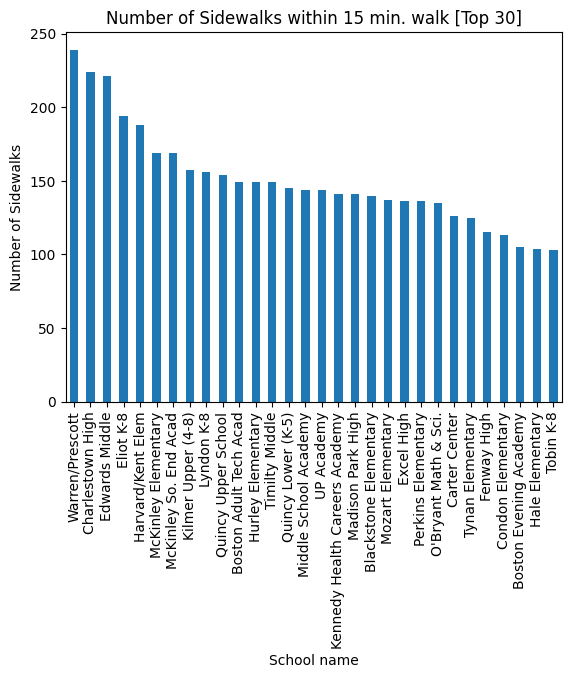

In [ ]:
import matplotlib.pyplot as plt
sidewalks_per_school = result[(result['distance'] <= 1.2 )& (result['cnt'] != 0.0)].groupby('SCH_NAME')['temp'].count()
sidewalks_per_school_top_30 = sidewalks_per_school.nlargest(30)
ax = sidewalks_per_school_top_30.plot.bar()

plt.xlabel("School name")
plt.ylabel("Number of Sidewalks")
plt.title("Number of Inaccessible Sidewalks within 15 min. walk [Top 30]")
# ax.bar_label(ax.containers[0], fmt='%d', label_type='edge')
plt.savefig("../graphs/sidewalks//number_of_sidwalks_15min_school.pdf")
plt.show()

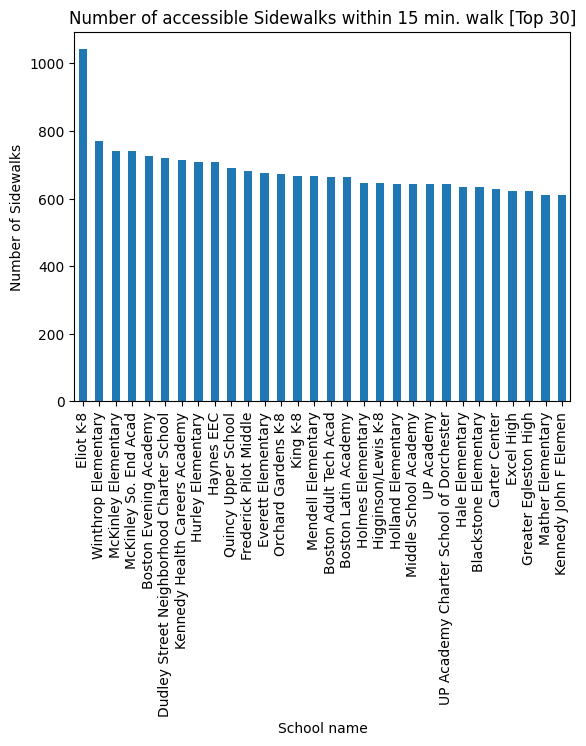

In [ ]:
import matplotlib.pyplot as plt
sidewalks_per_school = result[(result['distance'] <= 1.2 )& (result['cnt'] == 0.0)].groupby('SCH_NAME')['temp'].count()
sidewalks_per_school_top_30 = sidewalks_per_school.nlargest(30)
ax = sidewalks_per_school_top_30.plot.bar()

plt.xlabel("School name")
plt.ylabel("Number of Sidewalks")
plt.title("Number of accessible Sidewalks within 15 min. walk [Top 30]")
# ax.bar_label(ax.containers[0], fmt='%d', label_type='edge')
plt.savefig("../graphs/sidewalks//number_of_sidwalks_15min_school.pdf")
plt.show()

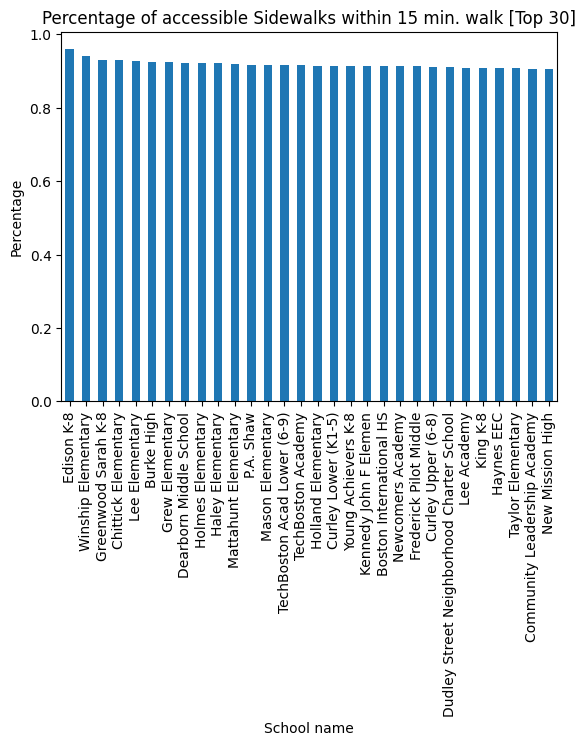

In [ ]:
accessible = result[(result['distance'] <= 1.2 )& (result['cnt'] == 0.0)].groupby('SCH_NAME')['temp'].count()
inaccessible =  result[(result['distance'] <= 1.2 )& (result['cnt'] != 0.0)].groupby('SCH_NAME')['temp'].count()

percentage_accesible = accessible/(accessible+inaccessible)



ax = percentage_accesible.nlargest(30).plot.bar()

plt.xlabel("School name")
plt.ylabel("Percentage")
plt.title("Percentage of accessible Sidewalks within 15 min. walk [Top 30]")
# ax.bar_label(ax.containers[0], fmt='%d', label_type='edge')
plt.savefig("../graphs/sidewalks//number_of_sidwalks_15min_school.pdf")
plt.show()

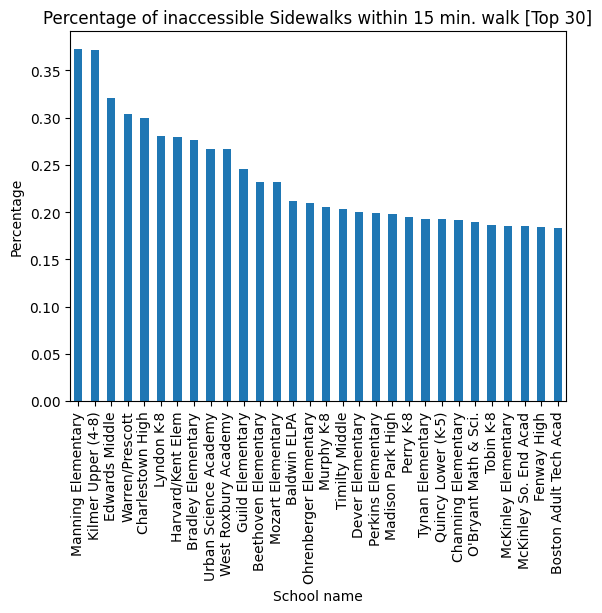

In [ ]:
accessible = result[(result['distance'] <= 1.2 )& (result['cnt'] == 0.0)].groupby('SCH_NAME')['temp'].count()
inaccessible =  result[(result['distance'] <= 1.2 )& (result['cnt'] != 0.0)].groupby('SCH_NAME')['temp'].count()

percentage_inaccesible = inaccessible/(accessible+inaccessible)



ax = percentage_inaccesible.nlargest(30).plot.bar()

plt.xlabel("School name")
plt.ylabel("Percentage")
plt.title("Percentage of inaccessible Sidewalks within 15 min. walk [Top 30]")
# ax.bar_label(ax.containers[0], fmt='%d', label_type='edge')
plt.savefig("../graphs/sidewalks//number_of_sidwalks_15min_school.pdf")
plt.show()